# Publication references by researcher

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all DataCite references of the DataCite publications, datasets and software authored by a particular researcher, using his/her ORCID ID.

In [31]:
# Prepare the R graphql client.

#install.packages("httr")
#install.packages("ghql")
#install.packages("jsonlite")
#install.packages("IRdisplay")
#install.packages("dplyr")
#install.packages("igraph")
#install.packages("RColorBrewer")

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")
library("RColorBrewer")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

In [32]:
# Generate the GraphQL query: find the researcher by ORCID ID, then fetch the first 50 publications, datasets and software with DataCite DOIs linked to that ORCID account.

query <- '{
  person(id: "https://orcid.org/0000-0003-1419-2405") {
    id
    type
    name
    publications(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    datasets(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    softwareSourceCodes(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
  }
}'

In [33]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [34]:
# Get the name of the researcher with ORCID ID https://orcid.org/0000-0003-1419-2405

display_markdown(data$data$person$name)

Martin Fenner

In [35]:
# Get the number of publications

display_json(data$data$person$publications$totalCount)
display_json(data$data$person$datasets$totalCount)
display_json(data$data$person$softwareSourceCodes$totalCount)

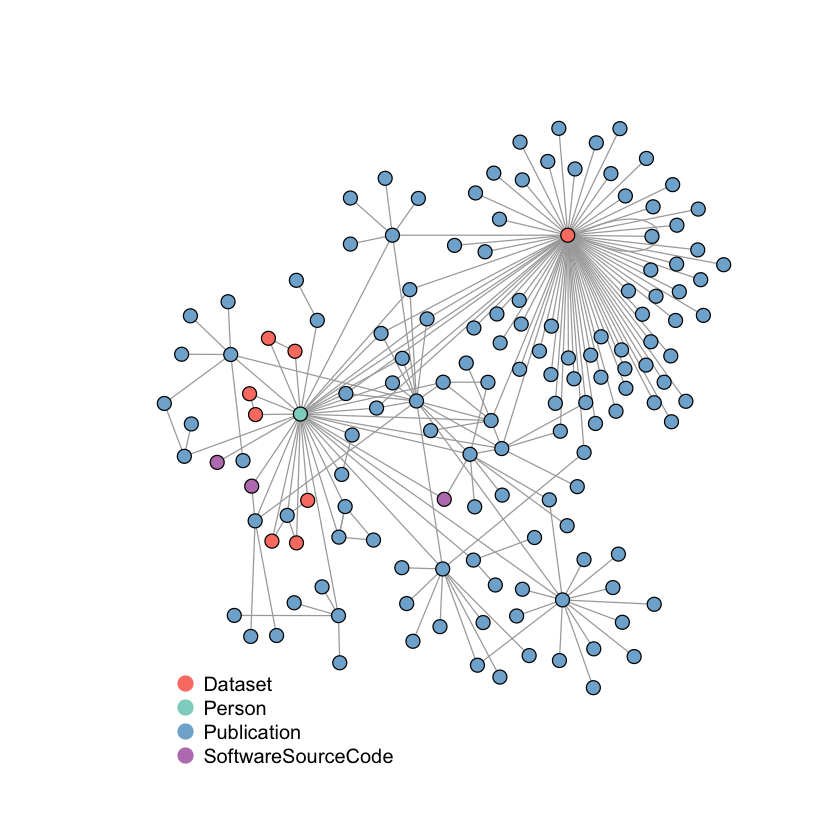

In [39]:
# generate data frame for nodes
people <- data.frame(id=data$data$person$id, pid_type=data$data$person$type)
publications <- data.frame(id=data$data$person$publications$nodes$id, pid_type=c('Publication'))
datasets <- data.frame(id=data$data$person$datasets$nodes$id, pid_type=data$data$person$datasets$nodes$type)
softwareSourceCodes <- data.frame(id=data$data$person$softwareSourceCodes$nodes$id, pid_type=data$data$person$softwareSourceCodes$nodes$type)
publication_references <- data.frame(id=bind_rows(data$data$person$publications$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
dataset_references <- data.frame(id=bind_rows(data$data$person$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
#software_references <- data.frame(id=bind_rows(data$data$person$softwareSourceCodes$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
nodes <- unique(rbind(people, publications, datasets, softwareSourceCodes, publication_references, dataset_references))

publication_edges <- data.frame(to=publications[,1], from=data$data$person$id)
dataset_edges <- data.frame(to=datasets[,1], from=data$data$person$id)
software_edges <- data.frame(to=softwareSourceCodes[,1], from=data$data$person$id)
edges <- unique(rbind(publication_edges, dataset_edges, software_edges))
    
# loop through nodes, as they can have more than one edge
publications_with_references <- bind_rows(data$data$person$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
datasets_with_references <- bind_rows(data$data$person$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
softwareSourceCodes_with_references <- bind_rows(data$data$person$softwareSourceCodes$nodes) %>% filter(lengths(relatedIdentifiers) != 0)

for (i in 1:nrow(publications_with_references)) {
  row <- data.frame(to=unlist(publications_with_references[i,3]), from=publications_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

for (i in 1:nrow(datasets_with_references)) {
  row <- data.frame(to=unlist(datasets_with_references[i,3]), from=datasets_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

#for (i in 1:nrow(softwareSourceCodes_with_references)) {
#  row <- data.frame(to=unlist(softwareSourceCodes_with_references[i,3]), from=softwareSourceCodes_with_references[i,1])
#  edges <- unique(rbind(edges, row))
#}

# express DOIs as URLs
nodes <- nodes %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
edges <- edges %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

# remove duplicates
nodes <- nodes %>% distinct(id, .keep_all = TRUE)

g <- graph_from_data_frame(d=unique(edges), vertices=unique(nodes))

# add node colors
cols <- brewer.pal(12, "Set3")
V(g)[(V(g)$pid_type=="Publication")]$color<-cols[5]
V(g)[(V(g)$pid_type=="Person")]$color<-cols[1]
V(g)[(V(g)$pid_type=="Dataset")]$color<-cols[4]
V(g)[(V(g)$pid_type=="SoftwareSourceCode")]$color<-cols[10]

# add labels to selected nodes
V(g)$label=NA

V(g)$size <- 5
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)
plot(g, layout=l, arrow.mode=0)

# Add a legend
# pid_type is sorted alphabetically: 'Dataset' 'Person' 'Publication' 'SoftwareSourceCode'
legend("bottomleft", legend=levels(as.factor(V(g)$pid_type)), col = cols[c(4,1,5,10)], bty = "n", pch=20 , pt.cex = 2.5, cex = 1, horiz = FALSE, inset = c(0.1, -0.1))

In [40]:
# Generate a list of formatted citations in APA format for the publications

ids <- substring(publications[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publications')
display_markdown(content(response, as = 'text'))

## Publications

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691

Friesike, S., &amp; Fenner, M. (2014). Schreiben. https://doi.org/10.2314/COSCV1.4

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691.V1

Fenner, M. (2015, August 17). From Pilot to Service. https://doi.org/10.5438/S8GF-0CK9

Fenner, M. (2015, October 26). Auto-Update Has Arrived! https://doi.org/10.5438/FERW-CWHQ

Fenner, M. (2015, September 16). Adding References to the DataCite Blog. https://doi.org/10.5438/2WFX-2HZ1

Fenner, M. (2016, December 15). Cool DOI's. https://doi.org/10.5438/55E5-T5C0

Fenner, M. (2015). Discussing the Scholarly Container. https://doi.org/10.5438/D9EQ-9DGA

Fenner, M. (2016, May 4). Thinking about CSV. https://doi.org/10.5438/4QX3-RP8Y

Fenner, M. (2016, May 13). Data catalog cards: simplifying article/data linking. https://doi.org/10.5438/CAB5-TEG0

Fenner, M. (2015, August 20). Digging into Metadata using R. https://doi.org/10.5438/1HV8-2GC2

Fenner, M. (2017, January 9). Using Schema.org for DOI Registration. https://doi.org/10.5438/0000-00CC

Fenner, M. (2017, April 28). A Content Negotiation Update. https://doi.org/10.5438/0000-01QJ

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120248

Fenner, M., Katz, D. S., Nielsen, L. H., &amp; Smith, A. (2018, May 17). DOI Registrations for Software. https://doi.org/10.5438/1NMY-9902

Garza, K., &amp; Fenner, M. (2018, June 1). Glad You Asked: A Snapshot of the Current State of Data Citation. https://doi.org/10.5438/H16Y-3D72

Fenner, M. (2016). Eating your own Dog Food. https://doi.org/10.14454/XJ8V-BJ37

Fenner, M. (2018, September 18). COUNTER Code of Practice for Research Data Usage Metrics release 1. https://doi.org/10.5438/NB24-T773

Lowenberg, D., Fenner, M., &amp; Chodacki, J. (2019). 5 Steps Towards a Dream State: Persistent &amp; Open Data Metrics. https://doi.org/10.5281/ZENODO.2547485

Lowenberg, D., Fenner, M., &amp; Chodacki, J. (2019). 5 Steps Towards a Dream State: Persistent &amp; Open Data Metrics. https://doi.org/10.5281/ZENODO.2547484

Fenner, M., Wass, J., Demeranville, T., Wimalaratne, S., &amp; Hallett, R. (2019). D2.2 PID Metadata Provenance. https://doi.org/10.5281/ZENODO.3248653

Wimalaratne, S., &amp; Fenner, M. (2019, June 24). Please welcome Sarala, our new Head of Infrastructure Services. https://doi.org/10.5438/AJ7F-H903

Fenner, M. (2019, July 1). Tracking the Growth of the PID Graph. https://doi.org/10.5438/BV9Z-DC66

Fenner, M. (2019). RDA Open Science Graphs for FAIR Data Interest Group. https://doi.org/10.5281/ZENODO.3361405

In [41]:
# Generate a list of formatted citations in APA format for the references (if they are DataCite DOIs)

ids <- references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## References')
display_markdown(content(response, as = 'text'))    

ERROR: Error in eval(expr, envir, enclos): Objekt 'references' nicht gefunden
